In [2]:
import numpy as np;
from visualize import plot_2, plot_3, plot_3d, plot_6;
from load_dataset import load_mnist_test, load_mnist_train;
from conduct_svm import svm;
from conduct_csc import nn_csc, csc, par_csc, par_nn_csc;
from pickless import output;
from pooling import forward;
from sporco import plot, util;
from sporco.admm import cbpdn
from conduct_svm import *;

In [6]:
def make_option():
    opt = {};
    # 訓練画像の枚数
    opt['train_amount'] = 500;
    # テスト画像の枚数
    opt['test_amount'] = 100;
    # フィルタのサイズ
    opt['d_size'] = [(5, 5, 1, 1, 6), (5, 5, 6, 16)];
    # スパースの尺度
    opt['lmbda'] = [0.05, 0.025];
    # 繰り返し回数
    opt['Iter'] = [400, 400];
    # NMFによる錐制約部分空間法における基底の数
    opt['d_num'] = 16;
    # PCAによる包括凸錐による部分空間法における累積寄与率のリスト・パラメータ
    opt["ratios"] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9];
    opt["params"] = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5];
    return opt;

In [7]:
opt = make_option();
train_data, train_label = load_mnist_train(opt["train_amount"]);
test_data, test_label = load_mnist_test(opt["test_amount"]);
train_data = np.expand_dims(train_data.transpose(1,2,0), 2);
test_data = np.expand_dims(test_data.transpose(1,2,0), 2);
test_data = np.expand_dims(test_data, -1);

load_mnist_train: return following shape arrays
imgs: (500, 32, 32)
labels: (500,)
load_mnist_test: return following shape arrays
imgs: (100, 32, 32)
labels: (100,)


### 学習用データセットで畳み込み辞書学習
第１層目:フォワードパスの計算中...
Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D     
--------------------------------------------------------------------------------------------------------
   0  1.29e+04  1.09e+04  4.04e+04  1.59e-16  7.26e-01  8.72e-01  3.00e+00  2.62e-01  3.57e-01  1.00e+01
   1  1.27e+04  9.74e+03  5.91e+04  2.85e-16  3.15e-01  1.45e+00  3.00e+00  1.83e-01  3.30e-01  1.00e+01
   2  9.23e+03  5.70e+03  7.05e+04  3.05e-16  1.73e-01  8.87e-01  3.00e+00  1.43e-01  1.94e-01  1.00e+01
   3  8.20e+03  4.68e+03  7.03e+04  3.51e-16  1.28e-01  8.20e-01  3.00e+00  1.08e-01  1.38e-01  1.00e+01
   4  7.39e+03  3.98e+03  6.82e+04  3.34e-16  9.13e-02  5.78e-01  3.00e+00  8.93e-02  1.30e-01  1.00e+01
   5  7.03e+03  3.68e+03  6.70e+04  2.75e-16  7.34e-02  4.49e-01  3.00e+00  7.23e-02  1.01e-01  1.00e+01
   6  6.73e+03  3.48e+03  6.50e+04  4.47e-16  5.90e-02  3.69e-01  3.00e+00  6.04e-02  8.33e-02  1.00e+01
   7  6.52e+

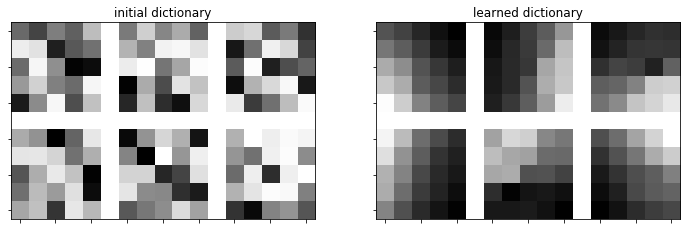

In [8]:
# 学習用データセットで辞書学習
print("### 学習用データセットで畳み込み辞書学習");

print("第１層目:フォワードパスの計算中...");
d0, D0, coef0 = nn_csc(input_ = train_data, d_size = opt['d_size'][0], lmbda = opt['lmbda'][0], Iter = opt['Iter'][0], visualize = True);
print("第１層目:プーリング中...");
coef0 = forward(coef0.squeeze().transpose(2,3,0,1), 2, 2, 2).transpose(1,2,3,0);

print("第２層目:フォワードパスの計算中...");
d1, D1, coef1 = nn_csc(input_ = coef0, d_size = opt['d_size'][1], lmbda = opt['lmbda'][1], Iter = opt['Iter'][1], visualize = False);
print("第２層目:プーリング中...");
coef2 = forward(coef1.squeeze().transpose(2,3,0,1), 2, 2, 2);
# output(opt, D0, coef0, D1, coef1);

In [9]:
# 学習用の非負特徴量(data_num, data_dim)
train_feature = coef2.reshape(opt["train_amount"], -1)

In [10]:
# テスト用データセットの係数算出
print("### テスト用データセットの係数算出 ###");

test_opt0 = cbpdn.ConvBPDN.Options({'Verbose': False, 'MaxMainIter': opt["Iter"][0], 'RelStopTol': 5e-3, 'AuxVarObj': False, 'NonNegCoef':True});
b0 = cbpdn.ConvBPDN(D0, test_data, opt["lmbda"][0], test_opt0);
print("第１層目:フォワードパスの計算中...");
test_coef0 = b0.solve();
print("第１層目:プーリング中...");
test_coef0 = forward(test_coef0.squeeze().transpose(2,3,0,1), 2, 2, 2).transpose(1,2,3,0);


test_opt1 = cbpdn.ConvBPDN.Options({'Verbose': False, 'MaxMainIter': opt["Iter"][1], 'RelStopTol': 5e-3, 'AuxVarObj': False, 'NonNegCoef':True});
test_coef0 = np.expand_dims(test_coef0, -1);
b1 = cbpdn.ConvBPDN(D1.squeeze(), test_coef0, opt["lmbda"][1], test_opt1);
print("第２層目:フォワードパスの計算中...");
test_coef1 = b1.solve();
print("第２層目:プーリング中...");
test_coef1 = forward(test_coef1.squeeze().transpose(2,3,0,1), 2, 2, 2).transpose(1,2,3,0);

test_feature = test_coef1.transpose(3, 0, 1, 2).reshape(opt["test_amount"], -1);
print("test_feature:", test_feature.shape);

### テスト用データセットの係数算出 ###
第１層目:フォワードパスの計算中...
第１層目:プーリング中...
第２層目:フォワードパスの計算中...
第２層目:プーリング中...
test_feature: (100, 1024)


In [11]:
# SVMによる分類
clf = train_svm(train_feature, train_label);
test_precision = test_svm(clf, test_feature, test_label);

Train precision:  0.996
Test precision:  0.93


In [12]:
# 錘を作るための関数郡
from sklearn.decomposition import NMF
def create_cone_NMF(feature, num):
    nmf = NMF(n_components=num);
    W = nmf.fit_transform(feature);
    H = nmf.components_;
    return nmf, H, W;

def restore_from_cone_NMF(feature, nmf):
    restore = nmf.inverse_transform(nmf.transform(feature));
    return restore;

In [13]:
# 学習データの錘を作成
# H: 錐の基底ベクトル
# W: 非負値結合係数
# nmf: NMFクラス

NMFs = [];
Hs = [];
Ws = [];
for i in range(10):
    print(str(i)+"番目のクラスの錐を作成中...");
    nmf, H, W = create_cone_NMF(train_feature[train_label == i], opt["d_num"]);
    NMFs.append(nmf);
    Hs.append(H);
    Ws.append(W);

0番目のクラスの錐を作成中...
1番目のクラスの錐を作成中...
2番目のクラスの錐を作成中...
3番目のクラスの錐を作成中...
4番目のクラスの錐を作成中...
5番目のクラスの錐を作成中...
6番目のクラスの錐を作成中...
7番目のクラスの錐を作成中...
8番目のクラスの錐を作成中...
9番目のクラスの錐を作成中...


In [14]:
# テストデータを錐へ射影
# restore: 射影したベクトル
restores = [];
for i in range(10):
    print(str(i)+"番目のクラスの錐で入力を再現中...")
    temp = restore_from_cone_NMF(test_feature, NMFs[i]);
    restores.append(temp);

0番目のクラスの錐で入力を再現中...
1番目のクラスの錐で入力を再現中...
2番目のクラスの錐で入力を再現中...
3番目のクラスの錐で入力を再現中...
4番目のクラスの錐で入力を再現中...
5番目のクラスの錐で入力を再現中...
6番目のクラスの錐で入力を再現中...
7番目のクラスの錐で入力を再現中...
8番目のクラスの錐で入力を再現中...
9番目のクラスの錐で入力を再現中...


In [15]:
from sklearn.metrics.pairwise import cosine_similarity;
CosArray = [];
for i in range(10):
    cos_array = cosine_similarity(test_feature, restores[i]);
    CosArray.append(np.diag(cos_array));
CosArray = np.array(CosArray);
predict_label = np.argmax(CosArray, axis = 0);
precision = sum(predict_label == test_label)/test_label.shape[0];
print('Test precision: ', precision);

Test precision:  0.88


In [16]:
def NMF_Classifier(train_feature, train_label, test_feature, test_label, from_, to_):
    accuracy = []
    for h in range(from_, to_+1):
        NMFs = [];
        Hs = [];
        Ws = [];
        for i in range(10):
            #print(str(i)+"番目のクラスの錐を作成中...");
            nmf, H, W = create_cone_NMF(train_feature[train_label == i], h);
            NMFs.append(nmf);
            Hs.append(H);
            Ws.append(W);
        restores = [];
        for i in range(10):
            #print(str(i)+"番目のクラスの錐で入力を再現中...")
            temp = restore_from_cone_NMF(test_feature, NMFs[i]);
            restores.append(temp);
        CosArray = [];
        for i in range(10):
            cos_array = cosine_similarity(test_feature, restores[i]);
            CosArray.append(np.diag(cos_array));            
        CosArray = np.array(CosArray);
        predict_label = np.argmax(CosArray, axis = 0);
        precision = sum(predict_label == test_label)/test_label.shape[0];
        accuracy.append(precision);
        print("d_num="+str(h)+": Test precision: ", precision);
    fig = plot.figure();
    ax = fig.add_subplot(111);
    ax.set_xlabel("# of basis");
    ax.set_ylabel("Accuracy");
    ax.plot(accuracy);
    ax.set_title("Cone restricted subspace method by NMF");
    fig.savefig("result/nmf.png")

d_num=1: Test precision:  0.76
d_num=2: Test precision:  0.86
d_num=3: Test precision:  0.87
d_num=4: Test precision:  0.87
d_num=5: Test precision:  0.9
d_num=6: Test precision:  0.89
d_num=7: Test precision:  0.86
d_num=8: Test precision:  0.89
d_num=9: Test precision:  0.87
d_num=10: Test precision:  0.89
d_num=11: Test precision:  0.89
d_num=12: Test precision:  0.89
d_num=13: Test precision:  0.89
d_num=14: Test precision:  0.89
d_num=15: Test precision:  0.88
d_num=16: Test precision:  0.9


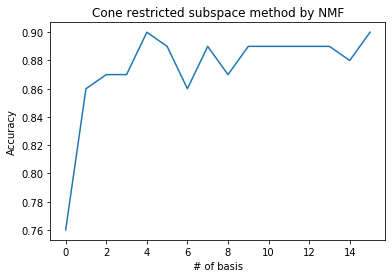

In [17]:
NMF_Classifier(train_feature, train_label, test_feature, test_label, 1, 16);

In [18]:
from sklearn.preprocessing import normalize
from sporco import prox
test_feature_norm = normalize(test_feature);

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
param = 1.0;
ratio = 0.9;
# feature = normalize(np.random.uniform(0.0, 1.0, (500, 1024)));
feature = normalize(test_feature);
pca = PCA(n_components=ratio);
pca.fit(feature);
variance = pca.explained_variance_;
mean = pca.mean_;
basis = pca.components_;
cone_basis = [];
cnt = 0;
for i in variance:
    cone_basis.append(mean+param*np.sqrt(i)*basis[cnt]);
    cone_basis.append(mean-param*np.sqrt(i)*basis[cnt]);
    cnt=cnt+1;
cone_basis = np.array(cone_basis);

In [20]:
from scipy.optimize import nnls;

def create_cone_PCA(feature, param, ratio):
    feature = normalize(feature);
    pca = PCA(n_components=ratio);
    pca.fit(feature);
    variance = pca.explained_variance_;
    mean = pca.mean_;
    basis = pca.components_;
    cone_basis = [];
    cnt = 0;
    for i in variance:
        cone_basis.append(mean+param*np.sqrt(i)*basis[cnt]);
        cone_basis.append(mean-param*np.sqrt(i)*basis[cnt]);
        cnt=cnt+1;
    cone_basis = np.array(cone_basis);
    return cone_basis;

def restore_from_cone_PCA(cone_basis, feature):
    feature = list(feature);
    restore = [];
    for i in feature:
        x = np.array(nnls(cone_basis.T, i)[0]);
        restore.append(cone_basis.T.dot(x));
    restore = np.array(restore);
    return restore;

In [21]:
from matplotlib import pyplot as plt
def PCA_Classifier(train_feature, train_label, test_feature, test_label, params, ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999, 0.9999]):
    fig = plot.figure();
    ax = fig.add_subplot(111);
    cmap = plt.get_cmap("tab10");
    ax.set_title("Cone restricted subspace method by Comprehensive cone");
    ax.set_xlabel("ratios");
    ax.set_ylabel("Accuracy");
    ax.set_ylim(0.8, 1.0);
    cnt=0;
    for param in params:
        accuracy = [];
        print("the parameter of scaling : "+str(param))
        for ratio in ratios:
            Cones = [];

            for i in range(10):
                #print(str(i)+"番目のクラスの錐を作成中...");
                cone = create_cone_PCA(train_feature[train_label == i], param, ratio);
                Cones.append(cone);
            restores = [];
            for i in range(10):
                #print(str(i)+"番目のクラスの錐で入力を再現中...")
                temp = restore_from_cone_PCA(Cones[i], test_feature);
                restores.append(temp);
            CosArray = [];
            for i in range(10):
                cos_array = cosine_similarity(test_feature, restores[i]);
                CosArray.append(np.diag(cos_array));

            CosArray = np.array(CosArray);
            predict_label = np.argmax(CosArray, axis = 0);
            precision = sum(predict_label == test_label)/test_label.shape[0];
            print("ratio="+str(ratio)+": Test precision: ", precision);
            accuracy.append(precision);
        ax.plot(accuracy, label = "k="+str(param), color = cmap(cnt));
        cnt=cnt+1;
    ax.legend();
    fig.savefig("result/Comprehensive.png");

the parameter of scaling : 0.5
ratio=0.1: Test precision:  0.84
ratio=0.2: Test precision:  0.84
ratio=0.3: Test precision:  0.83
ratio=0.4: Test precision:  0.84
ratio=0.5: Test precision:  0.84
ratio=0.6: Test precision:  0.84
ratio=0.7: Test precision:  0.84
ratio=0.8: Test precision:  0.84
ratio=0.9: Test precision:  0.84
the parameter of scaling : 1.0
ratio=0.1: Test precision:  0.83
ratio=0.2: Test precision:  0.87
ratio=0.3: Test precision:  0.87
ratio=0.4: Test precision:  0.88
ratio=0.5: Test precision:  0.88
ratio=0.6: Test precision:  0.88
ratio=0.7: Test precision:  0.88
ratio=0.8: Test precision:  0.88
ratio=0.9: Test precision:  0.88
the parameter of scaling : 1.5
ratio=0.1: Test precision:  0.83
ratio=0.2: Test precision:  0.86
ratio=0.3: Test precision:  0.88
ratio=0.4: Test precision:  0.9
ratio=0.5: Test precision:  0.9
ratio=0.6: Test precision:  0.9
ratio=0.7: Test precision:  0.9
ratio=0.8: Test precision:  0.9
ratio=0.9: Test precision:  0.9
the parameter of scali

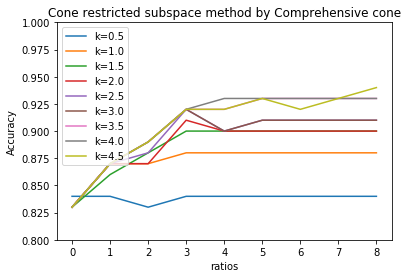

In [22]:
PCA_Classifier(train_feature, train_label, test_feature, test_label, opt["params"], opt["ratios"]);